In [27]:
%run '/home/drummond/Drive_Docs/Documents/Gradschool/Research/FPF/PIV/GitHub/FPF_PIV_CODE/Drummonds_Scripts/PIV.py'
#run "C:\Users\Charles Klewicki\Google Drive\school\Graduate\FPF Summer 2017\PIV Python Scripts\FPF_PIV_CODE\Drummonds_Scripts\PIV.py"

In [10]:
%run '/home/drummond/Drive_Docs/Documents/Gradschool/Research/FPF/PIV/GitHub/FPF_PIV_CODE/Drummonds_Scripts/hotwire.py'
#run "C:\Users\Charles Klewicki\Google Drive\school\Graduate\FPF Summer 2017\PIV Python Scripts\FPF_PIV_CODE\Drummonds_Scripts\hotwire.py"

In [4]:
import pandas as pd
import numpy as np
import PIV
import time
import sys
import h5py
from scipy.signal import medfilt
import matplotlib.pyplot as plt
import hotwire as hw
%matplotlib inline


################################################################
#   PURPOSE
#   1. Readin in PIV data_sets
#   2. Find Mask
#   3. Resize
#   4. Determine mean profiles and HO quantities
################################################################
#Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total:
        print()

def piv_readin_mod(base_name_input, data_sets, sizex, sizey):
	#setup range of datasets
    x_range = np.arange(1, data_sets+1)
    #initalize data
    count = 0
    temp_u = np.ndarray([len(x_range), sizex, sizey])
    temp_v = np.ndarray([len(x_range), sizex, sizey])
    #setup progressbar
    printProgressBar(0, len(x_range), prefix = 'Reading In:', suffix = 'Complete', length = 50)
    for i in x_range:
        #create file name for each txt file
        loc = base_name_input + '/B' + str('{0:05}'.format(i)) + '.txt'
        #read in txt file but skip first row
        temp = pd.read_csv(loc, sep='\t', skiprows=1, header=None)
        #rename columns to designated davis output
        temp.columns = ['Xlocation (mm)', 'Ylocation (mm)', 'U (m/sec)', 'V (m/sec)']
        #reorganize into seperate arrays
        temp_x = np.array(np.reshape(temp['Xlocation (mm)'], (sizex, sizey)))
        temp_y = np.array(np.reshape(temp['Ylocation (mm)'], (sizex, sizey)))
        temp_u[count] = np.array(np.reshape(temp['U (m/sec)'], (sizex, sizey)))
        temp_v[count] = np.array(np.reshape(temp['V (m/sec)'], (sizex, sizey)))
        count+=1
        printProgressBar(i, len(x_range), prefix = 'Reading In:', suffix = 'Complete', length = 50)
    x_axis = temp_x[0]
    y_axis = temp_y[:,0]
    print('Done Read in!')
    #sys.stdout.write("\n")
    return(x_axis, y_axis, temp_u, temp_v, x_range)


#This function is used to set bad and non-physical images to a nan value
def filt_images(u_vel, v_vel, Uinfinity, sizey):
	#count number of bad images
	count1 = 0
	#initalize the mean values which images will be filtered on
	Umean_top = np.zeros(len(u_vel))
	#compute means for top of images after above zero filter has been applied
	for j in range(0, len(u_vel[0,:])):
		Umean_top[j] = np.mean(np.mean(u_vel[j, int(2*(sizey/3)):-1]))
	####remove all images which have ~zero mean such that when STD filter is appled
	# the average is not skewed to towards zero
	for j in range(0, len(v_vel[0,:])):
		if Umean_top[j] < Uinfinity/10:
			u_vel[0, j] = np.nan
			v_vel[0, j] = np.nan
			count1+=1
	#compute new means for top of images after above zero filter has been applied
	for j in range(0, len(u_vel[0,:])):
		Umean_top[j] = np.mean(np.mean(u_vel[j, int(2*(sizey/3)):-1]))
	####Apply STD filter 
	#number of times to iterate through STD filter   
	num_loops = 4
	#width of filter in STD
	filter_width = 1
	for k in range(0, num_loops):
		#compute mean of top 1/3 of image for STD filtering
		for j in range(0, len(u_vel[0,:])):
			Umean_top[j] = np.mean(np.mean(u_vel[j, int(2*(sizey/3)):-1]))
		#STD filter  
		for j in range(0, len(u_vel[0,:])):
			#remove images with average value less than avg - x*STD
			if Umean_top[j] < np.nanmean(Umean_top) - filter_width * np.sqrt(np.nanvar(Umean_top)):
				u_vel[0, j] = np.nan
				v_vel[0, j] = np.nan
				count1+=1
			#remove images with average value greater than avg - x*STD
			if Umean_top[j] > np.nanmean(Umean_top) + filter_width * np.sqrt(np.nanvar(Umean_top)):
				u_vel[0, j] = np.nan
				v_vel[0, j] = np.nan
				count1+=1
	return(u_vel, v_vel, count1)

In [8]:
## INITIAL CODE USED FOR READING IN
#run air_prop.py
#Parameter set
date = '072117'
filter_width = 21
num_images = 10911
sizex = 129
sizey = 129
walloffset = 7.25 #mm
side_error = 5
u_infinity = 4.5

#list name of data set folders
base_name = dict()
#List the base name for each test to be read in and analyzed, names taken directly from folder
base_name[0] = '/home/drummond/Local_files/FPF/test_' + date + '/data/Cam_Date=170721_Time=160651_TR_SeqPIV_MP(2x16x16_50ov_ImgCorr)=unknown_02'
#base_name[0] = 'D:\test_072017\Cam_Date=170721_Time=160651_TR_SeqPIV_MP(2x16x16_50ov_ImgCorr)=unknown'

#Initalize variables
num_tests = len(base_name)
u = np.ndarray([num_tests, num_images, sizey, sizex])
v = np.ndarray([num_tests, num_images, sizey, sizex])
v_filt = np.ndarray([num_tests, num_images, sizey, sizex])
u_filt = np.ndarray([num_tests, num_images, sizey, sizex])
umean = np.ndarray([num_tests, sizey, sizex])
#vmean1 = np.ndarray([num_tests, sizey, sizex])
#mask = np.zeros([num_tests, 3])
umean_profile = dict()
vmean_profile = dict()
urms_profile = dict()
vrms_profile = dict()
uvprime_profile = dict()
for j in base_name:
	#Read in
	[x, y, u[j], v[j], x_range] = piv_readin_mod(base_name[j], num_images, sizey, sizex)
	#Filter Images
	[u_filt[j], v_filt[j], bad_im_count] = filt_images(u[j], v[j], u_infinity, sizey)
	#Obtain mean vector field
	umean[j] = np.nanmean(u_filt[j, :], axis=0)
	#vmean1[j] = np.nanmean(v_filt[j, :], axis=0)

#determine mask position
tempmask = PIV.mask_loc(umean[j])
mask = list(tempmask)
#use this to find the mean vel in each image, and look for bad images


## Resize vecotor field to crop out masked areas and
# create new vectors which take out the masked areas and any side errors
sizex_mask = mask[3] - mask[2] - side_error*2
sizey_mask = mask[1] - mask[0]
Umask = np.ndarray([num_tests, num_images, sizey_mask, sizex_mask])
Vmask = np.ndarray([num_tests, num_images, sizey_mask, sizex_mask])
umean = np.ndarray([num_tests, sizey_mask, sizex_mask])
vmean = np.ndarray([num_tests, sizey_mask, sizex_mask])
for j in base_name:
    Umask[j] = u_filt[j][:, mask[0]:mask[1], int(mask[2]+side_error):int(mask[3]-side_error)]
    Vmask[j] = v_filt[j][:, mask[0]:mask[1], int(mask[2]+side_error):int(mask[3]-side_error)]
    umean[j] = np.nanmean(Umask[j], axis=0)
    vmean[j] = np.nanmean(Vmask[j], axis=0)

## Determine RMS quantities ##
uprime = np.ndarray([num_tests, num_images, sizey_mask, sizex_mask])
vprime = np.ndarray([num_tests, num_images, sizey_mask, sizex_mask])
uvprime  = np.ndarray([num_tests, num_images, sizey_mask, sizex_mask])
uvprime_mean = np.ndarray([num_tests, sizey_mask, sizex_mask])
urms = np.ndarray([num_tests, sizey_mask, sizex_mask])
vrms = np.ndarray([num_tests, sizey_mask, sizex_mask])
for j in range(0, num_tests):
    for jj in range(0, num_images):
        uprime[j, jj] = ((Umask[j][jj]-umean[j]))
        vprime[j, jj] = ((Vmask[j][jj]-vmean[j]))
        uvprime[j, jj] = uprime[j, jj]*vprime[j, jj]
    uvprime_mean[j] = np.nanmean(uvprime[j], axis=0)
    urms[j] = np.nanmean(uprime[j]**2, axis=0)**(1/2)
    vrms[j] = np.nanmean(vprime[j]**2, axis=0)**(1/2)

## wall position adjustment ###########
#convert to m and take off wall position as seen in images
x = (x)/1000
y = (y-walloffset)/1000
xmask = x[ (mask[2]+side_error):(mask[3]-side_error) ]
ymask = y[ mask[0]:mask[1] ]
## Create Mean Profiles for each data set#######
for j in range(0, num_tests):
    umean_profile[j] = np.mean(umean[j], axis=1)
    vmean_profile[j] = np.mean(vmean[j], axis=1)
    urms_profile[j] = np.mean(urms[j], axis=1)
    vrms_profile[j] = np.mean(vrms[j], axis=1)
    uvprime_profile[j] = np.mean(uvprime_mean[j], axis=1)

## Average multiple profiles together
#use this if multiple tests are performed at the same condition
umean_profile_avg = np.zeros(len(umean_profile[0]))
vmean_profile_avg = np.zeros(len(umean_profile[0]))
urms_profile_avg = np.zeros(len(umean_profile[0]))
vrms_profile_avg = np.zeros(len(umean_profile[0]))
uvprime_profile_avg = np.zeros(len(umean_profile[0]))
#average datasets together
for j in range(0, num_tests):
    umean_profile_avg = umean_profile_avg + umean_profile[j]
    vmean_profile_avg = vmean_profile_avg + vmean_profile[j]
    urms_profile_avg = urms_profile_avg + urms_profile[j]
    vrms_profile_avg = vrms_profile_avg + vrms_profile[j]
    uvprime_profile_avg = uvprime_profile_avg + uvprime_profile[j]
#divide profiles by number of tests which were combined
umean_profile_avg = umean_profile_avg / num_tests
vmean_profile_avg = vmean_profile_avg / num_tests
urms_profile_avg = urms_profile_avg / num_tests
vrms_profile_avg = vrms_profile_avg / num_tests
uvprime_profile_avg = uvprime_profile_avg / num_tests

##calculate conf interval
conf = dict()
Neff = 75
conf['u'] =  (np.nanmean(np.nanmean(np.nanvar(Umask, axis=1), axis=0), axis=1))**(1/2) * (1/Neff)**(1/2)
conf['v'] =  (np.nanmean(np.nanmean(np.nanvar(Vmask, axis=1), axis=0), axis=1))**(1/2) * (1/Neff)**(1/2)
conf['urms'] =  (np.nanmean(np.nanvar(urms, axis=0), axis=1))**(1/2) * (1/(2*Neff-1))**(1/2)
conf['vrms'] =  (np.nanmean(np.nanvar(vrms, axis=0), axis=1))**(1/2) * (1/(2*Neff-1))**(1/2)
sigma_u = (np.nanmean(np.nanvar(Umask, axis=1), axis=0))**(1/2)
sigma_v = (np.nanmean(np.nanvar(Vmask, axis=1), axis=0))**(1/2)
conf['uvprime'] = np.nanmean(sigma_u * sigma_v * (1+ (np.nanmean(uvprime_mean, axis=0)/(sigma_u * sigma_v))**2 / (Neff - 1))**(1/2), axis=1)

Reading In: |██████████████████████████████████████████████████| 100.0% Complete
Done Read in!
Mask Found!


In [11]:
##  WRITE OUT DATA
###################
#open hdf5 file
hdf = pd.HDFStore('/home/drummond/Local_files/FPF/test_' + date + '/data/PIV_' + date + '.h5')
hdf.put('umean_profile_avg', pd.DataFrame(umean_profile_avg))
hdf.put('vmean_profile_avg', pd.DataFrame(vmean_profile_avg))
hdf.put('urms_profile_avg', pd.DataFrame(urms_profile_avg))
hdf.put('vrms_profile_avg', pd.DataFrame(vrms_profile_avg))
hdf.put('uvprime_profile_avg', pd.DataFrame(uvprime_profile_avg))
hdf.put('confidence', pd.DataFrame(conf))
hdf.put('xaxis', pd.Series(xmask))
hdf.put('yaxis', pd.Series(ymask))
hdf.put('mask', pd.DataFrame(mask))
hdf.close()

print('Data Saved!')

Data Saved!


In [24]:
%run "/home/drummond/Drive_Docs/Documents/Gradschool/Research/FPF/PIV/GitHub/FPF_PIV_CODE/Drummonds_Scripts/PIV_inner.py"
#run "C:\Users\Charles Klewicki\Google Drive\school\Graduate\FPF Summer 2017\PIV Python Scripts\FPF_PIV_CODE\Drummonds_Scripts\PIV_inner.py"

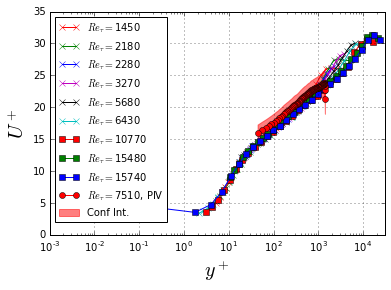

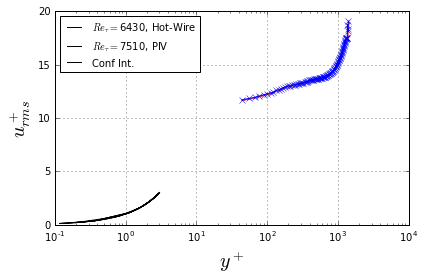

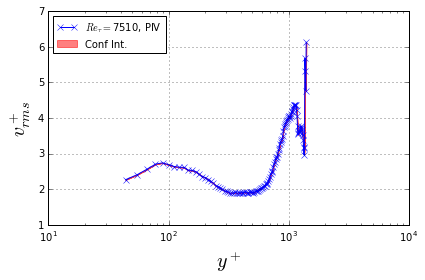

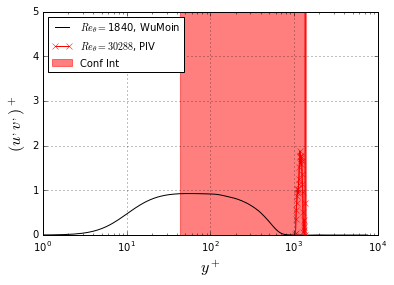

Done!


In [28]:
date = '072117'
num_tests = 1
sizex = 129  #Num vertical points
sizey = 129  #num horizontal points
#use folder instead of name and the rest is performed inside script
folder = '/home/drummond/Local_files/FPF/test_' + date + '/'
#name = 'D:/test_072017/PIV_' + date + '.h5'
utau = [.105]
inner(date,num_tests,sizex,sizey,folder,utau)

In [38]:
%run "/home/drummond/Drive_Docs/Documents/Gradschool/Research/FPF/PIV/GitHub/FPF_PIV_CODE/Drummonds_Scripts/PIV_Outer.py"
#run "C:\Users\Charles Klewicki\Google Drive\school\Graduate\FPF Summer 2017\PIV Python Scripts\FPF_PIV_CODE\Drummonds_Scripts\PIV_outer.py"

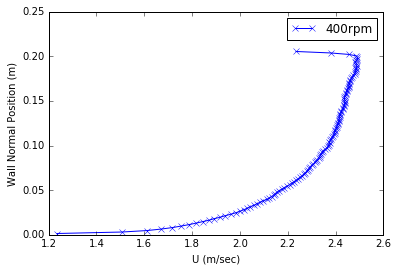

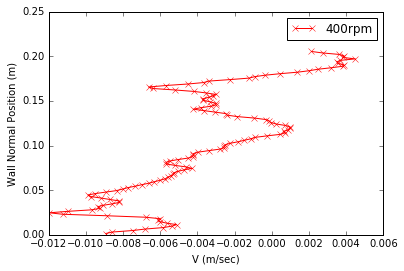

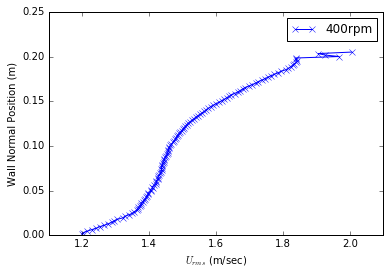

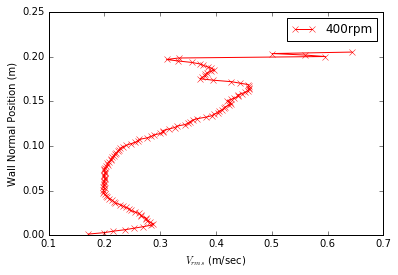

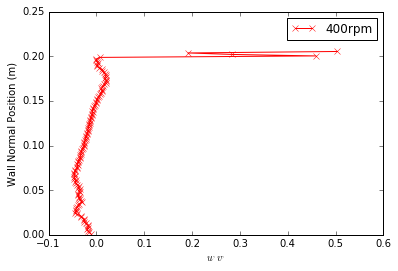

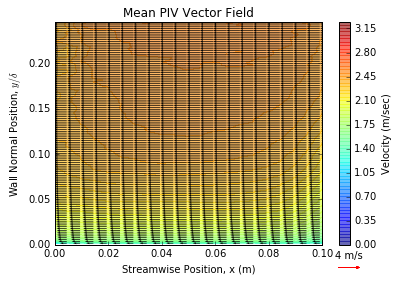

Done!


In [39]:
outer(date,num_tests,sizex,sizey,folder)